In [1]:
N_ROWZ = 5
import warnings
warnings.filterwarnings('ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import torch as tch
import torch.nn as nn
import torch.nn.functional as F 

from tqdm.notebook import tqdm 


In [3]:
## ==== The CSV ==== 
DDIR = "../../datasets/qin_lab/02__GUANGDONG_PM/" 
DFILE = f"{DDIR}/guangdong_pm__longfmt__three_years_en___n-448.csv"

In [4]:
dframe = pd.read_csv(DFILE)
print( f"No. Records: {len(dframe)},\nNo. Columns: {len(dframe.columns)}\n----" )


HUE_COL = 'y_status' ##<< based on naked_eye_vision
CAT_TO_NUMERIC = ['gender_en', 'gdp_group', 'school_nature_en', 'school_type_en', #'nationality_en', 
                  'dai_mirror_type_en', 'grade_en']
CAT_PREFIX = "_"

COLZ_RENAME = ["Height (cm)","Weight (kg)","Blood pressure (MMHG)"]
## Computed fields 
dframe[HUE_COL] = dframe['eye_status_en'].apply( lambda x: 0 if x=='normal' else 1) #
#dframe[HUE_COL] = dframe['check_dates__year'].apply( lambda x: 0 if x<=2019 else 1) #
for c in CAT_TO_NUMERIC:
    dframe[ f"{CAT_PREFIX}{c}" ] = dframe[ c ].astype('category').cat.codes

## renamez
dframe.rename( columns={ c : c.replace(" ","_").replace("(","").replace(")","") for c in COLZ_RENAME}, inplace=True)

colz = [c.replace(" ","_").replace("(","").replace(")","") for c in COLZ_RENAME]+['age', 'age_group','bmi', 'y_status','check_dates__year']+[ f"{CAT_PREFIX}{c}" for c in CAT_TO_NUMERIC]
dframe = dframe.filter( colz )
print( dframe.columns)
dframe.columns = ['Height_cm', 'Weight_kg', 'Blood_pressure_MMHG', 'Age', 'Age_group',
       'BMI', 'y_status', 'Tsxn__yr', 'Gender', 'GDP_group',
       'School_nature', 'School_type', 'Dtype','School_grade']

# dframe = dframe.filter( ['Tsxn_yr', 'Gender', 'Age', 'Age_group', 
#                   'BMI', 'Height_cm', 'Weight_kg', 'Blood_pressure_MMHG', 
#        'GDP_group', 'School_nature', 'School_type','School_grade',
#        'Dtype', 'y_status', ] ) 
dframe.sample(13).T#[dframe.columns[7:27]].T

dframe.columns

No. Records: 448,
No. Columns: 71
----
Index(['Height_cm', 'Weight_kg', 'Blood_pressure_MMHG', 'age', 'age_group',
       'bmi', 'y_status', 'check_dates__year', '_gender_en', '_gdp_group',
       '_school_nature_en', '_school_type_en', '_dai_mirror_type_en',
       '_grade_en'],
      dtype='object')


,409,361,316,162,225,231,1,124,330,271,447,175,131
Height_cm,137.4,129.0,129.0,152.7,149.5,126.1,154.7,157.4,115.5,131.1,132.5,146.2,142.5
Weight_kg,28.9,34.5,28.0,34.3,42.5,21.9,44.9,45.1,22.2,35.2,29.0,43.6,35.6
Blood_pressure_MMHG,114,90,110,118,124,103,123,124,95,80,106,118,110
Age,7.509184,9.122964,9.662426,11.257048,11.29046,8.915083,17.615566,11.227612,7.358791,8.321279,10.045475,11.11204,11.142779
Age_group,preteen,preteen,preteen,preteen,preteen,preteen,teen,preteen,preteen,preteen,preteen,preteen,preteen
BMI,15.308209,20.731927,16.825912,14.710114,19.015447,13.772537,18.76142,18.204011,16.641367,20.480346,16.518334,20.398195,17.531548
y_status,0,0,0,0,0,0,1,0,0,0,0,0,0
Tsxn__yr,2020,2021,2021,2020,2021,2019,2019,2019,2019,2019,2021,2020,2019
Gender,1,1,0,0,1,1,0,0,0,0,1,1,1
GDP_group,2,2,2,2,2,2,2,2,2,2,2,2,2


Index(['Height_cm', 'Weight_kg', 'Blood_pressure_MMHG', 'Age', 'Age_group',
       'BMI', 'y_status', 'Tsxn__yr', 'Gender', 'GDP_group', 'School_nature',
       'School_type', 'Dtype', 'School_grade'],
      dtype='object')

<AxesSubplot:xlabel='y_status', ylabel='count'>

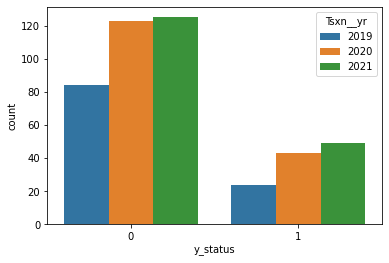

In [5]:
## class distribution 
sns.countplot( HUE_COL, hue='Tsxn__yr', data=dframe)

<AxesSubplot:>

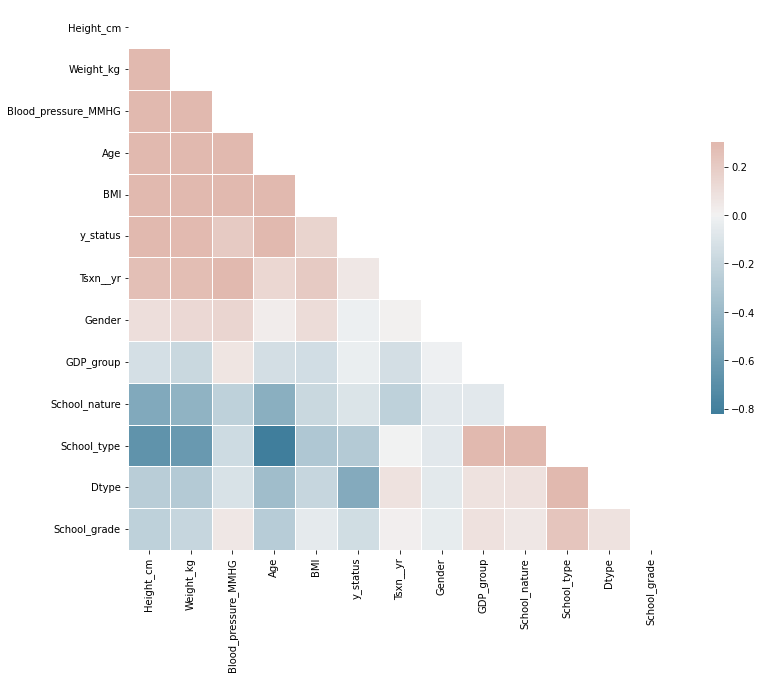

In [6]:
corr = dframe.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
_ = plt.figure(  figsize=(14,10))
sns.heatmap(corr, mask=mask, cmap=cmap, 
            vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# VIF
- https://www.statology.org/how-to-calculate-vif-in-python/ 
- https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/ 

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
## Find design matrix for ols
from patsy import dmatrices

In [21]:
def check_vif_of_eq( eq , df):
    ## find design matrix with 'xx' as response variable
    #get_design_matrix = lambda eq : dmatrices( eq, data=df , return_type='dataframe')
    y, X = dmatrices( eq, data=df , return_type='dataframe')
    #print(y.shape, X.shape, "\n", X.columns)
    ## resulting vif
    vif = pd.DataFrame()
    vif['variable'] = X.columns
    vif['VIF'] = [ variance_inflation_factor(X.values, i) for i in range(X.shape[1]) ] 
    return vif

In [22]:
## i. prepare your X matrix (n observations, p predictors)
my_predictor_variables = ['Gender',
                          #'Height_cm', 
                          #'Weight_kg', 
                          'Blood_pressure_MMHG', 
                          'Age', 
                          'Dtype',
                          'BMI',
                         ] 
X = dframe[ my_predictor_variables ]

## ii. compute VIF of each 
VIF = [ (pv, variance_inflation_factor(X.values, pi)) for pi, pv in enumerate(my_predictor_variables)]
VIF = pd.DataFrame.from_records(VIF)
VIF.columns = ("Predictor Variable", 'VIF')
VIF

,Predictor Variable,VIF
0,Gender,1.710313
1,Blood_pressure_MMHG,72.537906
2,Age,26.893356
3,Dtype,11.437785
4,BMI,52.385215


## ===== More

In [24]:
eqz = [
    'Age ~y_status  + Gender + BMI + GDP_group + School_nature + School_type + Dtype  + School_grade',
    'y_status ~ Age + Gender + BMI + GDP_group + School_nature + School_type + Dtype  + School_grade',   
    'y_status ~ Age + Gender + BMI + GDP_group + School_nature + Dtype  + School_grade',    
]

hwb = "Height_cm + Weight_kg + Blood_pressure_MMHG"

for i, eq in enumerate(eqz, 1):
    eq = eq+" + "+hwb if i < len(eqz)-1 else eq+" + Blood_pressure_MMHG"
    print("")
    print(eq[:30])
    print("\t",eq[30:60])
    print("\t",eq[60:97])
    print("\t",eq[97:])
    #print( check_vif_of_eq(eq, dframe) )
    check_vif_of_eq(eq, dframe) 
    print("-"*10)


Age ~y_status  + Gender + BMI 
	 + GDP_group + School_nature + 
	 School_type + Dtype  + School_grade +
	  Height_cm + Weight_kg + Blood_pressure_MMHG


,variable,VIF
0,Intercept,3840.922290
1,y_status,1.441966
2,Gender,1.054384
3,BMI,24.277400
4,GDP_group,1.243554
5,School_nature,1.529653
6,School_type,2.687726
7,Dtype,1.489343
8,School_grade,1.146265
9,Height_cm,46.092456


----------

y_status ~ Age + Gender + BMI 
	 + GDP_group + School_nature + 
	 School_type + Dtype  + School_grade +
	  Blood_pressure_MMHG


,variable,VIF
0,Intercept,300.859048
1,Age,4.578105
2,Gender,1.058841
3,BMI,1.281891
4,GDP_group,1.273918
5,School_nature,1.415013
6,School_type,4.262781
7,Dtype,1.215318
8,School_grade,1.123145
9,Blood_pressure_MMHG,1.509212


----------

y_status ~ Age + Gender + BMI 
	 + GDP_group + School_nature + 
	 Dtype  + School_grade + Blood_pressur
	 e_MMHG


,variable,VIF
0,Intercept,233.652544
1,Age,1.997064
2,Gender,1.043530
3,BMI,1.281344
4,GDP_group,1.081028
5,School_nature,1.347299
6,Dtype,1.197716
7,School_grade,1.122476
8,Blood_pressure_MMHG,1.376969


----------
